# FITS to hepfile


In [1]:
# first pip install astropy
!pip install astropy

In [2]:
# imports
import os, glob
import hepfile as hf
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [3]:
# download some "small" public fits images, unzip them, and clean up the directory
# this downloads three fits files from noirlab with observations of the eagle nebula at 3 different wavelengths
!wget 'https://noirlab.edu/public/media/archives/education/zip/edu008.zip'
!unzip -o 'edu008.zip'
!unzip -o '*.zip'
!rm -rf '__MACOSX'
!rm *.zip
!rm *.psd

--2023-06-26 12:44:55--  https://noirlab.edu/public/media/archives/education/zip/edu008.zip
Resolving noirlab.edu (noirlab.edu)... 54.213.236.16, 34.213.137.190, 52.35.39.104
Connecting to noirlab.edu (noirlab.edu)|54.213.236.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148278 (33M) [application/zip]
Saving to: ‘edu008.zip’

edu008.zip          100%[===================>]  32.57M  17.3MB/s    in 1.9s    

2023-06-26 12:44:57 (17.3 MB/s) - ‘edu008.zip’ saved [34148278/34148278]

Archive:  edu008.zip
  inflating: 502nmos.zip             
  inflating: __MACOSX/._502nmos.zip  
  inflating: eagle_composite.zip     
  inflating: __MACOSX/._eagle_composite.zip  
  inflating: 673nmos.zip             
  inflating: __MACOSX/._673nmos.zip  
  inflating: 656nmos.zip             
  inflating: __MACOSX/._656nmos.zip  
Archive:  eagle_composite.zip
  inflating: eagle.psd               

Archive:  656nmos.zip
  inflating: 656nmos.fits            

Archive:  673nmos.zip

In [4]:
# let's open the files
fitsfiles = glob.glob(os.path.join(os.getcwd(), '*.fits'))

fitsdata = []
for f in fitsfiles:
    hdu_list = fits.open(f)
    print(hdu_list.info()) # this shows all the info
    print()
    fitsdata.append(hdu_list)

Filename: /home/nfranz/research/hepfile/sandbox/673nmos.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     289   (1600, 1600)   float32   
  1  673nmos_cvt.tab    1 TableHDU       353   1R x 49C   [D25.17, D25.17, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, A1, E15.7, I12, I12, D25.17, D25.17, A8, A8, I12, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, I12, I12, I12, I12, I12, I12, I12, I12, A48, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7]   
None

Filename: /home/nfranz/research/hepfile/sandbox/502nmos.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     290   (1600, 1600)   float32   
  1  502nmos_cvt.tab    1 TableHDU       353   1R x 49C   [D25.17, D25.17, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, A1, E15.7, I12, I12, D25.17, D25.17, A8, A8, I12, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, I12, I12, I12

      CRVAL1           CRVAL2      CRPIX1 CRPIX2    CD1_1         CD1_2         CD2_1         CD2_2     ... MEANC10  MEANC25  MEANC50  MEANC100 MEANC200 MEANC300 BACKGRND
----------------- ---------------- ------ ------ ------------ ------------- ------------- ------------- ... -------- -------- -------- -------- -------- -------- --------
274.7115229948199 -13.816390682904  386.5  396.0 1.878013e-05 -2.031193e-05 -2.029358e-05 -1.879711e-05 ... 12.11311 12.13334 13.59485 14.88939 12.93392 12.34968 7.897364
      CRVAL1              CRVAL2       CRPIX1 CRPIX2    CD1_1         CD1_2         CD2_1     ... MEANC10  MEANC25  MEANC50  MEANC100 MEANC200 MEANC300 BACKGRND
------------------ ------------------- ------ ------ ------------ ------------- ------------- ... -------- -------- -------- -------- -------- -------- --------
274.71130937176997 -13.816000630103998  386.5  396.0 1.878013e-05 -2.031193e-05 -2.029358e-05 ... 10.52821 10.84973 10.78265 10.71748 9.907546  8.59161 3.285868
    

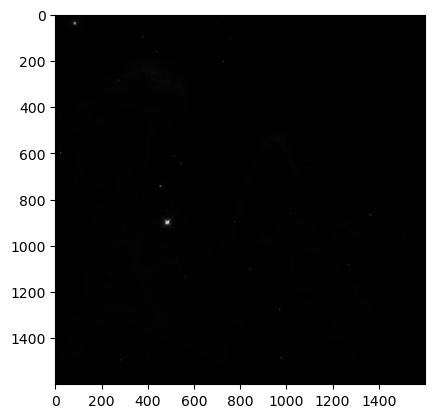

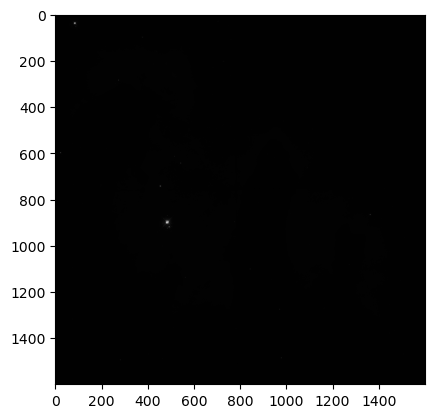

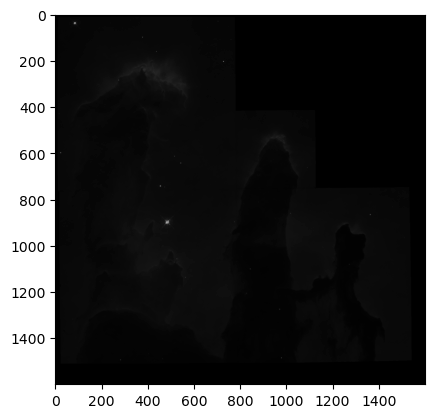

In [5]:
allinfo = []
imgs = []
for d in fitsdata:
    img = np.array(d[0].data)
    info = Table(d[1].data)

    print(info)
    plt.figure()
    plt.imshow(img.T, cmap='Greys_r')
    
    allinfo.append(info)
    imgs.append(img)

In [6]:
# we can think of each of these images as "events" and create a dictionary from them

events = []
for img, meta in zip(imgs, allinfo):
    
    event_dict = {}
    for key in meta.keys():
        # these are all the singleton values
        event_dict[key] = meta[key].value[0]
        
    event_dict['data'] = {} # initialize a subdict for the image data
    for i, row in enumerate(img):
        event_dict['data'][f'row_{i}'] = row
    
    events.append(event_dict)

In [7]:
# put this data in a hepfile
data = hf.dict_tools.dictlike_to_hepfile(events, 'eagle-nebula.h5', write_hepfile=True)

Writing the hdf5 file from the awkward array...
Metadata added


In [8]:
key = "_SINGLETONSGROUPFORSTORAGE_"
datalist = ['COUNTER', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'DATAMIN', 'DATAMAX', 'MIR_REVR', 'ORIENTAT', 'FILLCNT', 'ERRCNT', 'FPKTTIME', 'LPKTTIME', 'CTYPE1', 'CTYPE2', 'DETECTOR', 'DEZERO', 'BIASEVEN', 'BIASODD', 'GOODMIN', 'GOODMAX', 'DATAMEAN', 'GPIXELS', 'SOFTERRS', 'CALIBDEF', 'STATICD', 'ATODSAT', 'DATALOST', 'BADPIXEL', 'OVERLAP', 'PHOTMODE', 'PHOTFLAM', 'PHOTZPT', 'PHOTPLAM', 'PHOTBW', 'MEDIAN', 'MEDSHADO', 'HISTWIDE', 'SKEWNESS', 'MEANC10', 'MEANC25', 'MEANC50', 'MEANC100', 'MEANC200', 'MEANC300', 'BACKGRND']
stra = np.string_(key)

mydataset = []
strb = np.string_("")
nvals = len(datalist)
for i, val in enumerate(datalist):
    strb += np.string_(val)
    if i < nvals - 1:
        strb += np.string_("__:__")
mydataset.append([stra, strb])
mydataset

[[b'_SINGLETONSGROUPFORSTORAGE_',
  b'COUNTER__:__CRVAL1__:__CRVAL2__:__CRPIX1__:__CRPIX2__:__CD1_1__:__CD1_2__:__CD2_1__:__CD2_2__:__DATAMIN__:__DATAMAX__:__MIR_REVR__:__ORIENTAT__:__FILLCNT__:__ERRCNT__:__FPKTTIME__:__LPKTTIME__:__CTYPE1__:__CTYPE2__:__DETECTOR__:__DEZERO__:__BIASEVEN__:__BIASODD__:__GOODMIN__:__GOODMAX__:__DATAMEAN__:__GPIXELS__:__SOFTERRS__:__CALIBDEF__:__STATICD__:__ATODSAT__:__DATALOST__:__BADPIXEL__:__OVERLAP__:__PHOTMODE__:__PHOTFLAM__:__PHOTZPT__:__PHOTPLAM__:__PHOTBW__:__MEDIAN__:__MEDSHADO__:__HISTWIDE__:__SKEWNESS__:__MEANC10__:__MEANC25__:__MEANC50__:__MEANC100__:__MEANC200__:__MEANC300__:__BACKGRND']]

In [9]:
hepfile_data, bucket = hf.load('eagle-nebula.h5')

Building the indices...

Built the indices!
Data is read in and input file is closed.


In [15]:
hepfile_data['_GROUPS_']

{'_SINGLETONS_GROUP_': ['CRVAL1',
  'CRVAL2',
  'CRPIX1',
  'CRPIX2',
  'CD1_1',
  'CD1_2',
  'CD2_1',
  'CD2_2',
  'DATAMIN',
  'DATAMAX',
  'MIR_REVR',
  'ORIENTAT',
  'FILLCNT',
  'ERRCNT',
  'FPKTTIME',
  'LPKTTIME',
  'CTYPE1',
  'CTYPE2',
  'DETECTOR',
  'DEZERO',
  'BIASEVEN',
  'BIASODD',
  'GOODMIN',
  'GOODMAX',
  'DATAMEAN',
  'GPIXELS',
  'SOFTERRS',
  'CALIBDEF',
  'STATICD',
  'ATODSAT',
  'DATALOST',
  'BADPIXEL',
  'OVERLAP',
  'PHOTMODE',
  'PHOTFLAM',
  'PHOTZPT',
  'PHOTPLAM',
  'PHOTBW',
  'MEDIAN',
  'MEDSHADO',
  'HISTWIDE',
  'SKEWNESS',
  'MEANC10',
  'MEANC25',
  'MEANC50',
  'MEANC100',
  'MEANC200',
  'MEANC300',
  'BACKGRND'],
 'data': ['ndata',
  'row_0',
  'row_1',
  'row_10',
  'row_100',
  'row_1000',
  'row_1001',
  'row_1002',
  'row_1003',
  'row_1004',
  'row_1005',
  'row_1006',
  'row_1007',
  'row_1008',
  'row_1009',
  'row_101',
  'row_1010',
  'row_1011',
  'row_1012',
  'row_1013',
  'row_1014',
  'row_1015',
  'row_1016',
  'row_1017',
  'row

In [11]:
hf.awkward_tools.hepfile_to_awkward(hepfile_data)

<Array [{CRVAL1: 275, CRVAL2: -13.8, ...}, ...] type='3 * {CRVAL1: float64,...'>

In [12]:
meta

CRVAL1,CRVAL2,CRPIX1,CRPIX2,CD1_1,CD1_2,CD2_1,CD2_2,DATAMIN,DATAMAX,MIR_REVR,ORIENTAT,FILLCNT,ERRCNT,FPKTTIME,LPKTTIME,CTYPE1,CTYPE2,DETECTOR,DEZERO,BIASEVEN,BIASODD,GOODMIN,GOODMAX,DATAMEAN,GPIXELS,SOFTERRS,CALIBDEF,STATICD,ATODSAT,DATALOST,BADPIXEL,OVERLAP,PHOTMODE,PHOTFLAM,PHOTZPT,PHOTPLAM,PHOTBW,MEDIAN,MEDSHADO,HISTWIDE,SKEWNESS,MEANC10,MEANC25,MEANC50,MEANC100,MEANC200,MEANC300,BACKGRND
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,int64,int64,float64,float64,str8,str8,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,str48,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
274.71149247724,-13.816384007183999,386.5,396.0,1.878013e-05,-2.031193e-05,-2.029358e-05,-1.879711e-05,0.0,0.0,T,-131.9115,0,0,49808.732454364894,49808.732622188996,RA---TAN,DEC--TAN,4,311.3041,311.3347,311.2736,20.02589,5584.467,89.2569,559905,0,80081,0,15,0,0,0,"WFPC2,4,A2D7,F656N,,CAL",1.52899e-16,-21.1,6563.585,55.16187,93.54508,66.10242,62.41553,-0.1202522,126.9503,128.0693,134.1882,132.23,114.3746,100.2731,42.37756


In [13]:
hepfile_data['_GROUPS_']

{'_SINGLETONS_GROUP_': ['CRVAL1',
  'CRVAL2',
  'CRPIX1',
  'CRPIX2',
  'CD1_1',
  'CD1_2',
  'CD2_1',
  'CD2_2',
  'DATAMIN',
  'DATAMAX',
  'MIR_REVR',
  'ORIENTAT',
  'FILLCNT',
  'ERRCNT',
  'FPKTTIME',
  'LPKTTIME',
  'CTYPE1',
  'CTYPE2',
  'DETECTOR',
  'DEZERO',
  'BIASEVEN',
  'BIASODD',
  'GOODMIN',
  'GOODMAX',
  'DATAMEAN',
  'GPIXELS',
  'SOFTERRS',
  'CALIBDEF',
  'STATICD',
  'ATODSAT',
  'DATALOST',
  'BADPIXEL',
  'OVERLAP',
  'PHOTMODE',
  'PHOTFLAM',
  'PHOTZPT',
  'PHOTPLAM',
  'PHOTBW',
  'MEDIAN',
  'MEDSHADO',
  'HISTWIDE',
  'SKEWNESS',
  'MEANC10',
  'MEANC25',
  'MEANC50',
  'MEANC100',
  'MEANC200',
  'MEANC300',
  'BACKGRND'],
 'data': ['ndata',
  'row_0',
  'row_1',
  'row_10',
  'row_100',
  'row_1000',
  'row_1001',
  'row_1002',
  'row_1003',
  'row_1004',
  'row_1005',
  'row_1006',
  'row_1007',
  'row_1008',
  'row_1009',
  'row_101',
  'row_1010',
  'row_1011',
  'row_1012',
  'row_1013',
  'row_1014',
  'row_1015',
  'row_1016',
  'row_1017',
  'row

In [14]:
events[0]

{'CRVAL1': 274.7115229948199,
 'CRVAL2': -13.816390682904,
 'CRPIX1': 386.5,
 'CRPIX2': 396.0,
 'CD1_1': 1.878013e-05,
 'CD1_2': -2.031193e-05,
 'CD2_1': -2.029358e-05,
 'CD2_2': -1.879711e-05,
 'DATAMIN': 0.0,
 'DATAMAX': 0.0,
 'MIR_REVR': 'T',
 'ORIENTAT': -131.9115,
 'FILLCNT': 0,
 'ERRCNT': 0,
 'FPKTTIME': 49808.792871032194,
 'LPKTTIME': 49808.7930388563,
 'CTYPE1': 'RA---TAN',
 'CTYPE2': 'DEC--TAN',
 'DETECTOR': 4,
 'DEZERO': 311.0648,
 'BIASEVEN': 311.0896,
 'BIASODD': 311.0401,
 'GOODMIN': -0.7421596,
 'GOODMAX': 3563.879,
 'DATAMEAN': 10.50985,
 'GPIXELS': 559911,
 'SOFTERRS': 0,
 'CALIBDEF': 80081,
 'STATICD': 0,
 'ATODSAT': 9,
 'DATALOST': 0,
 'BADPIXEL': 0,
 'OVERLAP': 0,
 'PHOTMODE': 'WFPC2,4,A2D7,F673N,,CAL                         ',
 'PHOTFLAM': 6.045451e-17,
 'PHOTZPT': -21.1,
 'PHOTPLAM': 6732.239,
 'PHOTBW': 30.78069,
 'MEDIAN': 8.660032,
 'MEDSHADO': 12.83916,
 'HISTWIDE': 4.099397,
 'SKEWNESS': 0.04649998,
 'MEANC10': 12.11311,
 'MEANC25': 12.13334,
 'MEANC50': 13.5